# Sentiment Analysis using twitter data

Simple Deep Neural Network, that predicts tweet sentiment. The model can be greatly improved using various <br/>
word vectorization techniques and Recurrent Neural Networks.


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
import tflearn as tflearn
from nltk.corpus import stopwords
import preprocessor as p
import re
import numpy as np
from sklearn import preprocessing


In [22]:

def all_stop_words():
    stop_words = stopwords.words('english')
    add_stopwords = [",", "*" , ")" , "(" ,".","theres","know","one","though","vinci","ive","da","book","im","went",
                    "potter","brokeback","mountain","harry","code","mission","impossible","movie","movies","i","ya",
                    "yet","yall"]
    for w in add_stopwords:
        stop_words.append(w)
    return stop_words


stop_words = all_stop_words()
def training_data_df():
    
    training_data = open("./data/twitter_data.txt",mode='r')
    training_array =[]
    for d in training_data:
        training_dict = {}
        sent_tweet_array = d.split('\t')
        training_dict['tweet'] = sent_tweet_array[1].lower()
        training_dict['cleaned_tweet'] =remove_stop_words(sent_tweet_array[1].lower())
        training_dict['positive'] =int(sent_tweet_array[0])
        training_array.append(training_dict)
    training_df = pd.DataFrame(training_array)
    return training_df

def sentiment(sentiment_prob):
    if sentiment_prob[0]>sentiment_prob[1]:
        return "positive"
    return "negative"

def remove_stop_words(tweet_text):
    tweet_text = re.sub(r'[?|$|.|!]',r'',tweet_text)
    tweet_text = re.sub(r'[^a-zA-Z0-9 ]',r'',tweet_text)
    result = ""
    for word in tweet_text.split():            
        if word not in stop_words:
            result = result +" "+word.lower()

    return result.lstrip()

def get_word_frequency(tweet_list):
    word_dict = {} 
    result_array=[]
    for tw in tweet_list:
        for word in tw.split():
            if word in word_dict.keys():
                word_dict[word] = word_dict[word]+1
                continue
            word_dict[word] = 1
    for k in word_dict.keys():
        result_array.append({'word':k, 'count':word_dict[k]})
    return pd.DataFrame(result_array,columns=['count','word'])


def common_pos_words(df_data):
    return common_words_filter(df_data,1)

def common_neg_words(df_data):
    return common_words_filter(df_data,0)

def common_words_filter(df_data,sent):
    pos_tweet =df_data[df_data["positive"] ==sent]
    all_tweets = pos_tweet["tweet"].str.cat(sep='|')
    common_words=[]
    for pos_tw in pos_tweet["tweet"]:
        for tw in all_tweets.split('|'):
            if pos_tw == tw:
                continue
            tw_list = list(tw.split())
            pos_list = list(pos_tw.split())
            inter = list(set(tw_list).intersection(pos_list))
            for word in inter:
                if word not in common_words:
                    common_words.append(word)
    return common_words

In [23]:
training_data = training_data_df()
training_data["neg"] = training_data["positive"].apply(lambda x: 0 if x==1 else 1)
vect = CountVectorizer(stop_words=all_stop_words())
print("All data:",training_data.shape[0])

All data: 7086


In [24]:
training_data.head(10)

,cleaned_tweet,positive,tweet,neg
0,awesome,1,the da vinci code book is just awesome.\n,0
1,first clive cussler ever read even books like ...,1,this was the first clive cussler i've ever rea...,0
2,liked lot,1,i liked the da vinci code a lot.\n,0
3,liked lot,1,i liked the da vinci code a lot.\n,0
4,liked ultimatly didnt seem hold,1,i liked the da vinci code but it ultimatly did...,0
5,thats even exaggeration midnight walmart buy a...,1,that's not even an exaggeration ) and at midni...,0
6,loved want something better different,1,"i loved the da vinci code, but now i want some...",0
7,thought great kite runner,1,"i thought da vinci code was great, same with k...",0
8,actually good,1,the da vinci code is actually a good movie...\n,0
9,thought pretty good,1,i thought the da vinci code was a pretty good ...,0


In [25]:
training_data = training_data[['positive','neg','cleaned_tweet', 'tweet']]
training_data.values

array([[1, 0, 'awesome', 'the da vinci code book is just awesome.\n'],
       [1, 0,
        'first clive cussler ever read even books like relic plausible',
        "this was the first clive cussler i've ever read, but even books like relic, and da vinci code were more plausible than this.\n"],
       [1, 0, 'liked lot', 'i liked the da vinci code a lot.\n'],
       ..., 
       [0, 1, 'sit watching mtv awards reminded much despised',
        'as i sit here, watching the mtv movie awards, i am reminded of how much i despised the movie brokeback mountain.\n'],
       [0, 1, 'ok horrible',
        'ok brokeback mountain is such a horrible movie.\n'],
       [0, 1, 'oh terrible',
        'oh, and brokeback mountain was a terrible movie.\n']], dtype=object)

### One-hot Encode

In [28]:
vect.fit(training_data["cleaned_tweet"])
word_matrix = vect.transform(training_data["cleaned_tweet"]).toarray()
print(word_matrix.shape)

(7086, 2069)


In [29]:
num_features = word_matrix.shape[1]
print("Total features: ",num_features)
classes = training_data.values[:,:2]

Total features:  2069


In [30]:
trX,testX,trY,testY = train_test_split(word_matrix,classes)   
print("Training data:",trX.shape[0])

Training data: 5314


# Deep Neural Network


Consists of : 
<ul>
<li>Input layer </li> 
<li>Hidden layer with 300 neurons</li> 
<li>Output softmax layer, which outputs the likelyhood of a class: [1,0]</li>
</ul>

<img src="./data/nn-architecture.png"/>

In [85]:
tf.reset_default_graph()
input_data = tflearn.input_data(shape=[None, num_features])
init_weights = tflearn.initializations.truncated_normal(shape=None,dtype=tf.float32, seed=None)
layer1 = tflearn.layers.fully_connected(input_data,300,activation='sigmoid',weights_init=init_weights,regularizer='L2')
net  =tflearn.layers.fully_connected(layer1 , 2,activation='softmax',regularizer='L2')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')
model = tflearn.DNN(net,tensorboard_verbose=3)


In [86]:
model.fit(trX,trY,n_epoch=10,show_metric=True)
evl = model.evaluate(testX,testY)
print("Evaluation: ",evl)

Training Step: 839  | total loss: 0.06920 | time: 5.578s
| Adam | epoch: 010 | loss: 0.06920 - acc: 0.9905 -- iter: 5312/5314
Training Step: 840  | total loss: 0.06767 | time: 5.638s
| Adam | epoch: 010 | loss: 0.06767 - acc: 0.9923 -- iter: 5314/5314
--
Evaluation:  [0.99322799097065462]


             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       761
        1.0       1.00      0.99      0.99      1011

avg / total       0.99      0.99      0.99      1772

AUC = 0.9933


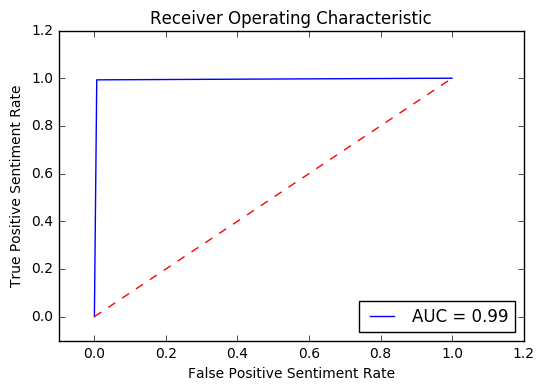

In [148]:
from sklearn.metrics import roc_curve, auc
def auc_curve():
    test_y=testY[:,0]
    pred = []
    i=0
    for t in testX:
        p = model.predict([t])
        p_toarray = np.asarray(p)[0]
        if p_toarray[0]>p_toarray[1]:
            pred.append(1.0)
        else:
            pred.append(0.0)
    print(metrics.classification_report(test_y.astype(float), np.asarray(pred)))
    print(metrics.confusion_matrix(test_y.astype(float), pred))
    fpr, tpr, thresholds = metrics.roc_curve(test_y, np.asarray(pred))
    roc_auc = auc(fpr, tpr)
    print('AUC = %0.4f'% roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Sentiment Rate')
    plt.xlabel('False Positive Sentiment Rate')
    plt.show()
    

auc_curve()

# Inspecting training data

### Positive sentiment

In [114]:
for t in training_data[training_data["positive"] ==1]["tweet"].head(10):
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: the da vinci code book is just awesome.

[ 0.97038788  0.02961217]
sentiment: positive
--------
Tweet: this was the first clive cussler i've ever read, but even books like relic, and da vinci code were more plausible than this.

[ 0.93533415  0.06466589]
sentiment: positive
--------
Tweet: i liked the da vinci code a lot.

[ 0.80056423  0.19943585]
sentiment: positive
--------
Tweet: i liked the da vinci code a lot.

[ 0.80056423  0.19943585]
sentiment: positive
--------
Tweet: i liked the da vinci code but it ultimatly didn't seem to hold it's own.

[ 0.77269202  0.22730799]
sentiment: positive
--------
Tweet: that's not even an exaggeration ) and at midnight we went to wal-mart to buy the da vinci code, which is amazing of course.

[ 0.62022918  0.37977079]
sentiment: positive
--------
Tweet: i loved the da vinci code, but now i want something better and different!..

[ 0.91257775  0.08742226]
sentiment: positive
--------
Tweet: i thought da vinci code was great, same with kit

### Negative sentiment

In [115]:

for t in training_data[training_data["positive"] ==0]["tweet"].head(10):
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: da vinci code was a terrible movie.

[ 0.13090219  0.86909783]
sentiment: negative
--------
Tweet: then again, the da vinci code is super shitty movie, and it made like 700 million.

[ 0.80618703  0.19381297]
sentiment: positive
--------
Tweet: the da vinci code comes out tomorrow, which sucks.

[ 0.03794273  0.96205723]
sentiment: negative
--------
Tweet: i thought the da vinci code movie was really boring.

[ 0.0553035   0.94469649]
sentiment: negative
--------
Tweet: god, yahoo games has this truly-awful looking da vinci code-themed skin on it's chessboard right now.

[ 0.33391207  0.66608799]
sentiment: negative
--------
Tweet: da vinci code does suck.

[ 0.07236701  0.92763293]
sentiment: negative
--------
Tweet: and better...-we all know da vinci code is bogus and inaccurate.

[ 0.37601653  0.6239835 ]
sentiment: negative
--------
Tweet: last time, da vinci code is also a bit disappointing to me, because many things written in the book is never mentioned in movie.

[ 0.460

### Custom data

In [140]:
testing_tweets = [
                  "The product was bad",
                  "I love this product",
                  "It was an ok experience",
                  "Do you hate me ?",
                  "Brokeback Mountain was boring.","excited for a change in 2017","I win!!","I am a winner"]
for t in testing_tweets:
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: The product was bad
[ 0.51106882  0.48893115]
sentiment: positive
--------
Tweet: I love this product
[ 0.97221279  0.02778714]
sentiment: positive
--------
Tweet: It was an ok experience
[ 0.29885435  0.70114565]
sentiment: negative
--------
Tweet: Do you hate me ?
[ 0.05492244  0.9450776 ]
sentiment: negative
--------
Tweet: Brokeback Mountain was boring.
[ 0.10410561  0.89589441]
sentiment: negative
--------
Tweet: excited for a change in 2017
[ 0.4390558   0.56094426]
sentiment: negative
--------
Tweet: I win!!
[ 0.48284903  0.517151  ]
sentiment: negative
--------
Tweet: I am a winner
[ 0.44101396  0.55898601]
sentiment: negative
--------
